# Modification de la structure du modèle

In [28]:
import random
import numpy as np
import os
import time
%matplotlib inline
import matplotlib.pyplot as mp
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as om
import torchvision as tv
import torch.utils.data as dat

if torch.cuda.is_available():     # Make sure GPU is available
    print("Computing with GPU")
    dev = torch.device("cuda:0")
    kwar = {'num_workers': 8, 'pin_memory': True}
    cpu = torch.device("cpu")
else:
    print("Warning: CUDA not found, CPU only.")
    dev = torch.device("cpu")
    kwar = {}
    cpu = torch.device("cpu")

np.random.seed(551)

Computing with GPU


## Modifier la structure du modèle

Dans un premier temps, essayons de modifier la structure du modèle pour voir comment cela affecte ses performances. Pour cela nous allons jouer sur les éléments suivants :
- Le nombre de convolutions
- La taille des filtres utilisés
- Le nombre de neurones dans les couches denses en fin de modèle.

Afin d'automatiser ces différents tests, modifions un peu la classe MedNet et créons une fonction train_model qui contient tout le code d'entraînement :

In [38]:
class MedNet(nn.Module):
    def __init__(self,xDim,yDim,numC, num_convs=(5, 10), conv_sizes=(7, 7), fc_sizes=(400, 80), add_dropout=False): # Pass image dimensions and number of labels when initializing a model   
        super(MedNet,self).__init__()  # Extends the basic nn.Module to the MedNet class
        # The parameters here define the architecture of the convolutional portion of the CNN. Each image pixel
        # has numConvs convolutions applied to it, and convSize is the number of surrounding pixels included
        # in each convolution. Lastly, the numNodesToFC formula calculates the final, remaining nodes at the last
        # level of convolutions so that this can be "flattened" and fed into the fully connected layers subsequently.
        # Each convolution makes the image a little smaller (convolutions do not, by default, "hang over" the edges
        # of the image), and this makes the effective image dimension decreases.
        
        self.add_dropout = add_dropout
        
        numConvs1 = num_convs[0]
        convSize1 = conv_sizes[0]
        numConvs2 = num_convs[1]
        convSize2 = conv_sizes[1]
        numNodesToFC = numConvs2*(xDim-(convSize1-1)-(convSize2-1))*(yDim-(convSize1-1)-(convSize2-1))

        # nn.Conv2d(channels in, channels out, convolution height/width)
        # 1 channel -- grayscale -- feeds into the first convolution. The same number output from one layer must be
        # fed into the next. These variables actually store the weights between layers for the model.
        
        self.cnv1 = nn.Conv2d(1, numConvs1, convSize1)
        self.cnv2 = nn.Conv2d(numConvs1, numConvs2, convSize2)

        # These parameters define the number of output nodes of each fully connected layer.
        # Each layer must output the same number of nodes as the next layer begins with.
        # The final layer must have output nodes equal to the number of labels used.
        
        fcSize1 = fc_sizes[0]
        fcSize2 = fc_sizes[1]
        
        # nn.Linear(nodes in, nodes out)
        # Stores the weights between the fully connected layers
        
        self.ful1 = nn.Linear(numNodesToFC,fcSize1)
        if self.add_dropout: self.drop1 = nn.Dropout(0.5)
        self.ful2 = nn.Linear(fcSize1, fcSize2)
        if self.add_dropout: self.drop2 = nn.Dropout(0.5)
        self.ful3 = nn.Linear(fcSize2,numC)
        
    def forward(self,x):
        # This defines the steps used in the computation of output from input.
        # It makes uses of the weights defined in the __init__ method.
        # Each assignment of x here is the result of feeding the input up through one layer.
        # Here we use the activation function elu, which is a smoother version of the popular relu function.
        
        x = F.elu(self.cnv1(x)) # Feed through first convolutional layer, then apply activation
        x = F.elu(self.cnv2(x)) # Feed through second convolutional layer, apply activation
        x = x.view(-1,self.num_flat_features(x)) # Flatten convolutional layer into fully connected layer
        x = F.elu(self.ful1(x)) # Feed through first fully connected layer, apply activation
        if self.add_dropout: x = self.drop1(x)
        x = F.elu(self.ful2(x)) # Feed through second FC layer, apply output
        if self.add_dropout: x = self.drop2(x)
        x = self.ful3(x)        # Final FC layer to output. No activation, because it's used to calculate loss
        return x

    def num_flat_features(self, x):  # Count the individual nodes in a layer
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
def train_model(params, trainX, trainY, validX, validY, testX, testY, verbose=False, add_dropout=False): # params est un dictionnaire qui contient les structures de CNN à essayer
    
    model = MedNet(imageWidth,imageHeight,numClass, add_dropout=add_dropout, **params).to(dev)

    learnRate = 0.01          # Define a learning rate.
    maxEpochs = 100            # Maximum training epochs
    t2vRatio = 1.2            # Maximum allowed ratio of validation to training loss
    t2vEpochs = 3             # Number of consecutive epochs before halting if validation loss exceeds above limit
    batchSize = 300           # Batch size. Going too large will cause an out-of-memory error.
    trainBats = nTrain // batchSize       # Number of training batches per epoch. Round down to simplify last batch
    validBats = nValid // batchSize       # Validation batches. Round down
    testBats = -(-nTest // batchSize)     # Testing batches. Round up to include all
    CEweights = torch.zeros(numClass)     # This takes into account the imbalanced dataset.
    for i in trainY.tolist():             #      By making rarer images count more to the loss, 
        CEweights[i].add_(1)              #      we prevent the model from ignoring them.
    CEweights = 1. / CEweights.clamp_(min=1.)                     # Weights should be inversely related to count
    CEweights = (CEweights * numClass / CEweights.sum()).to(dev)  # The weights average to 1
    opti = om.SGD(model.parameters(), lr = learnRate)   # Initialize an optimizer


    for i in range(maxEpochs):
        model.train()                     # Set model to training mode
        epochLoss = 0.
        permute = torch.randperm(nTrain)  # Shuffle data to randomize batches
        trainX = trainX[permute,:,:,:]
        trainY = trainY[permute]
        for j in range(trainBats):        # Iterate over batches
            opti.zero_grad()              # Zero out gradient accumulated in optimizer
            batX = trainX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)   # Slice shuffled data into batches
            batY = trainY[j*batchSize:(j+1)*batchSize].to(dev)         # .to(dev) moves these batches to the GPU
            yOut = model(batX)            # Evalute predictions
            loss = F.cross_entropy(yOut, batY,weight=CEweights)        # Compute loss
            epochLoss += loss.item()      # Add loss
            loss.backward()               # Backpropagate loss
            opti.step()                   # Update model weights using optimizer
        validLoss = 0.
        permute = torch.randperm(nValid)  # We go through the exact same steps, without backprop / optimization
        validX = validX[permute,:,:,:]    # in order to evaluate the validation loss
        validY = validY[permute]
        model.eval()                      # Set model to evaluation mode
        with torch.no_grad():             # Temporarily turn off gradient descent
            for j in range(validBats):
                opti.zero_grad()
                batX = validX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)
                batY = validY[j*batchSize:(j+1)*batchSize].to(dev)
                yOut = model(batX)
                validLoss += F.cross_entropy(yOut, batY,weight=CEweights).item()
        epochLoss /= trainBats            # Average loss over batches and print
        validLoss /= validBats
        if verbose: print("Epoch = {:-3}; Training loss = {:.4f}; Validation loss = {:.4f}".format(i,epochLoss,validLoss))
        if validLoss > t2vRatio * epochLoss:
            t2vEpochs -= 1                # Test if validation loss exceeds halting threshold
            if t2vEpochs < 1:
                if verbose: print("Validation loss too high; halting to prevent overfitting")
                break

    confuseMtx = np.zeros((numClass,numClass),dtype=int)    # Create empty confusion matrix
    model.eval()
    with torch.no_grad():
        permute = torch.randperm(nTest)                     # Shuffle test data
        testX = testX[permute,:,:,:]
        testY = testY[permute]
        for j in range(testBats):                           # Iterate over test batches
            batX = testX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)
            batY = testY[j*batchSize:(j+1)*batchSize].to(dev)
            yOut = model(batX)                              # Pass test batch through model
            pred = yOut.max(1,keepdim=True)[1]              # Generate predictions by finding the max Y values
            for j in torch.cat((batY.view_as(pred), pred),dim=1).tolist(): # Glue together Actual and Predicted to
                confuseMtx[j[0],j[1]] += 1                  # make (row, col) pairs, and increment confusion matrix
    correct = sum([confuseMtx[i,i] for i in range(numClass)])   # Sum over diagonal elements to count correct predictions
    if verbose: 
        print(f"Correct predictions: {correct} of {nTest}. Accuracy: {correct/nTest*100}%")
        print("Confusion Matrix:")
        print(confuseMtx)
        print(classNames)
    return correct/nTest

  



Pour gagner du temps, commençons par entraîner notre modèle avec un échantillon de nos données uniquement en testant différentes structures de CNN. Cela nous permettra d'identifier les configurations les plus performantes, puis de tester ces dernières sur l'ensemble des données.

In [30]:
images_to_use = 5000 # Proportion des images à utiliser 

dataDir = 'resized'               # The main data directory
classNames = os.listdir(dataDir)  # Each type of image can be found in its own subdirectory
numClass = len(classNames)        # Number of types = number of subdirectories

imageFiles = [[os.path.join(dataDir,classNames[i],x) for x in os.listdir(os.path.join(dataDir,classNames[i]))]
              for i in range(numClass)]                     # A nested list of filenames
numEach = [len(imageFiles[i]) for i in range(numClass)]     # A count of each type of image
imageFilesList = []               # Created an un-nested list of filenames
imageClass = []                   # The labels -- the type of each individual image in the list
for i in range(numClass):
    imageFilesList.extend(imageFiles[i])
    imageClass.extend([i]*numEach[i])
    
joined_list = list(zip(imageFilesList, imageClass))
random.shuffle(joined_list)
imageFilesList, imageClass = zip(*joined_list)
imageFilesList = imageFilesList[:images_to_use]
imageClass = imageClass[:images_to_use]

numTotal = len(imageClass)        # Total number of images
imageWidth, imageHeight = Image.open(imageFilesList[0]).size         # The dimensions of each image

print("There are",numTotal,"images in",numClass,"distinct categories")
print("Label names:",classNames)
print("Image dimensions:",imageWidth,"x",imageHeight)

There are 5000 images in 6 distinct categories
Label names: ['ChestCT', 'CXR', 'BreastMRI', 'Hand', 'HeadCT', 'AbdomenCT']
Image dimensions: 64 x 64


In [31]:
toTensor = tv.transforms.ToTensor()
def scaleImage(x):          # Pass a PIL image, return a tensor
    y = toTensor(x)
    if(y.min() < y.max()):  # Assuming the image isn't empty, rescale so its values run from 0 to 1
        y = (y - y.min())/(y.max() - y.min()) 
    z = y - y.mean()        # Subtract the mean value of the image
    return z

imageTensor = torch.stack([scaleImage(Image.open(x)) for x in imageFilesList])  # Load, scale, and stack image (X) tensor
classTensor = torch.tensor(imageClass)  # Create label (Y) tensor
print("Rescaled min pixel value = {:1.3}; Max = {:1.3}; Mean = {:1.3}"
      .format(imageTensor.min().item(),imageTensor.max().item(),imageTensor.mean().item()))

validFrac = 0.1   # Define the fraction of images to move to validation dataset
testFrac = 0.1    # Define the fraction of images to move to test dataset
validList = []
testList = []
trainList = []

for i in range(numTotal):
    rann = np.random.random() # Randomly reassign images
    if rann < validFrac:
        validList.append(i)
    elif rann < testFrac + validFrac:
        testList.append(i)
    else:
        trainList.append(i)
        
nTrain = len(trainList)  # Count the number in each set
nValid = len(validList)
nTest = len(testList)
print("Training images =",nTrain,"Validation =",nValid,"Testing =",nTest)

trainIds = torch.tensor(trainList)    # Slice the big image and label tensors up into
validIds = torch.tensor(validList)    #       training, validation, and testing tensors
testIds = torch.tensor(testList)
trainX = imageTensor[trainIds,:,:,:]
trainY = classTensor[trainIds]
validX = imageTensor[validIds,:,:,:]
validY = classTensor[validIds]
testX = imageTensor[testIds,:,:,:]
testY = classTensor[testIds]


Rescaled min pixel value = -0.739; Max = 0.97; Mean = -2.88e-09
Training images = 4016 Validation = 511 Testing = 473


Le code ci-dessous teste automatiquement toutes les combinaisons de paramètres à partir du dictionnaire params_values.

In [23]:
# /!\ EXÉCUTION TRÈS LONGUE /!\ 
import itertools

params_values = {"num_convs": [(5, 10), (5, 5), (3, 5), (3, 3), (4, 4), (2, 4), (2, 3), (6, 6), (7, 7), (8, 8)],
                "conv_sizes": [(7, 7), (5, 5), (3, 3), (6, 6), (4, 4)],
                "fc_sizes": [(400, 80), (100, 50), (50, 30), (30, 20), (200, 50), (200, 30), (100, 40), (80, 30), (80, 40)]}

keys = list(params_values)
results = []
for values in itertools.product(*map(params_values.get, keys)):
    params = dict(zip(keys, values))
    print(params)
    res = train_model(params, trainX, trainY, validX, validY, testX, testY)
    results.append((params, res))
    print(f"Parameters: {params} // Accuracy: {res*100}%")

{'num_convs': (5, 10), 'conv_sizes': (7, 7), 'fc_sizes': (400, 80)}


ZeroDivisionError: float division by zero

On peut maintenant trier les différentes configurations par accuracy obtenue et les afficher :

In [31]:
import pandas as pd

results_df = pd.DataFrame(results, columns=["configuration", "accuracy"])
results_df.sort_values(by="accuracy", inplace=True, ascending=False)
for index, row in results_df.iterrows():
    print(f"{row['configuration']} // Accuracy: {row['accuracy']}")

{'num_convs': (5, 10), 'conv_sizes': (7, 7), 'fc_sizes': (200, 30)} // Accuracy: 0.9617021276595744
{'num_convs': (3, 3), 'conv_sizes': (7, 7), 'fc_sizes': (50, 30)} // Accuracy: 0.9617021276595744
{'num_convs': (5, 10), 'conv_sizes': (5, 5), 'fc_sizes': (30, 20)} // Accuracy: 0.9617021276595744
{'num_convs': (5, 10), 'conv_sizes': (7, 7), 'fc_sizes': (100, 50)} // Accuracy: 0.9617021276595744
{'num_convs': (3, 5), 'conv_sizes': (7, 7), 'fc_sizes': (100, 50)} // Accuracy: 0.9617021276595744
{'num_convs': (3, 5), 'conv_sizes': (7, 7), 'fc_sizes': (200, 30)} // Accuracy: 0.9574468085106383
{'num_convs': (5, 5), 'conv_sizes': (7, 7), 'fc_sizes': (30, 20)} // Accuracy: 0.9574468085106383
{'num_convs': (3, 5), 'conv_sizes': (7, 7), 'fc_sizes': (400, 80)} // Accuracy: 0.9553191489361702
{'num_convs': (5, 10), 'conv_sizes': (5, 5), 'fc_sizes': (100, 50)} // Accuracy: 0.9553191489361702
{'num_convs': (5, 5), 'conv_sizes': (7, 7), 'fc_sizes': (200, 50)} // Accuracy: 0.9531914893617022
{'num_con

Nous pouvons maintenant essayer les configurations les plus prometteuses présentées ci-dessous avec la totalité du jeu de données :

In [39]:
best_configs = [
    {'num_convs': (5, 10), 'conv_sizes': (7, 7), 'fc_sizes': (200, 30)},
    {'num_convs': (3, 3), 'conv_sizes': (7, 7), 'fc_sizes': (50, 30)},
    {'num_convs': (5, 10), 'conv_sizes': (5, 5), 'fc_sizes': (30, 20)},
    {'num_convs': (5, 10), 'conv_sizes': (7, 7), 'fc_sizes': (100, 50)},
    {'num_convs': (3, 5), 'conv_sizes': (7, 7), 'fc_sizes': (100, 50)},
    {'num_convs': (5, 5), 'conv_sizes': (7, 7), 'fc_sizes': (30, 20)},
    {'num_convs': (3, 5), 'conv_sizes': (7, 7), 'fc_sizes': (400, 80)}
               ]


dataDir = 'resized'               # The main data directory
classNames = os.listdir(dataDir)  # Each type of image can be found in its own subdirectory
numClass = len(classNames)        # Number of types = number of subdirectories
imageFiles = [[os.path.join(dataDir,classNames[i],x) for x in os.listdir(os.path.join(dataDir,classNames[i]))]
              for i in range(numClass)]                     # A nested list of filenames
numEach = [len(imageFiles[i]) for i in range(numClass)]     # A count of each type of image
imageFilesList = []               # Created an un-nested list of filenames
imageClass = []                   # The labels -- the type of each individual image in the list
for i in range(numClass):
    imageFilesList.extend(imageFiles[i])
    imageClass.extend([i]*numEach[i])
numTotal = len(imageClass)        # Total number of images
imageWidth, imageHeight = Image.open(imageFilesList[0]).size         # The dimensions of each image

print("There are",numTotal,"images in",numClass,"distinct categories")
print("Label names:",classNames)
print("Label counts:",numEach)
print("Image dimensions:",imageWidth,"x",imageHeight)

toTensor = tv.transforms.ToTensor()
def scaleImage(x):          # Pass a PIL image, return a tensor
    y = toTensor(x)
    if(y.min() < y.max()):  # Assuming the image isn't empty, rescale so its values run from 0 to 1
        y = (y - y.min())/(y.max() - y.min()) 
    z = y - y.mean()        # Subtract the mean value of the image
    return z

imageTensor = torch.stack([scaleImage(Image.open(x)) for x in imageFilesList])  # Load, scale, and stack image (X) tensor
classTensor = torch.tensor(imageClass)  # Create label (Y) tensor
print("Rescaled min pixel value = {:1.3}; Max = {:1.3}; Mean = {:1.3}"
      .format(imageTensor.min().item(),imageTensor.max().item(),imageTensor.mean().item()))

validFrac = 0.1   # Define the fraction of images to move to validation dataset
testFrac = 0.1    # Define the fraction of images to move to test dataset
validList = []
testList = []
trainList = []

for i in range(numTotal):
    rann = np.random.random() # Randomly reassign images
    if rann < validFrac:
        validList.append(i)
    elif rann < testFrac + validFrac:
        testList.append(i)
    else:
        trainList.append(i)
        
nTrain = len(trainList)  # Count the number in each set
nValid = len(validList)
nTest = len(testList)
print("Training images =",nTrain,"Validation =",nValid,"Testing =",nTest)
trainIds = torch.tensor(trainList)    # Slice the big image and label tensors up into
validIds = torch.tensor(validList)    #       training, validation, and testing tensors
testIds = torch.tensor(testList)
trainX = imageTensor[trainIds,:,:,:]
trainY = classTensor[trainIds]
validX = imageTensor[validIds,:,:,:]
validY = classTensor[validIds]
testX = imageTensor[testIds,:,:,:]
testY = classTensor[testIds]

There are 58954 images in 6 distinct categories
Label names: ['ChestCT', 'CXR', 'BreastMRI', 'Hand', 'HeadCT', 'AbdomenCT']
Label counts: [10000, 10000, 8954, 10000, 10000, 10000]
Image dimensions: 64 x 64
Rescaled min pixel value = -0.786; Max = 0.972; Mean = -3.33e-09
Training images = 47132 Validation = 5974 Testing = 5848


In [33]:

for config in best_configs:
    res = train_model(config, trainX, trainY, validX, validY, testX, testY, verbose=True)
    results.append((params, res))
    print(f"Parameters: {params} // Accuracy: {res*100}%")

Epoch =   0; Training loss = 0.6556; Validation loss = 0.2138
Epoch =   1; Training loss = 0.1502; Validation loss = 0.1316
Epoch =   2; Training loss = 0.0975; Validation loss = 0.0901
Epoch =   3; Training loss = 0.0680; Validation loss = 0.0688
Epoch =   4; Training loss = 0.0514; Validation loss = 0.0545
Epoch =   5; Training loss = 0.0409; Validation loss = 0.0429
Epoch =   6; Training loss = 0.0345; Validation loss = 0.0378
Epoch =   7; Training loss = 0.0286; Validation loss = 0.0318
Epoch =   8; Training loss = 0.0241; Validation loss = 0.0329
Epoch =   9; Training loss = 0.0215; Validation loss = 0.0271
Epoch =  10; Training loss = 0.0182; Validation loss = 0.0260
Validation loss too high; halting to prevent overfitting
Correct predictions: 5832 of 5869. Accuracy: 99.3695689214517%
Confusion Matrix:
[[1001    0    0    0    0    7]
 [   0  970    0    4    0    0]
 [   2    0  880    0    0    0]
 [   1    2    1  973    7    0]
 [   0    0    0    0  998    2]
 [  11    0    

La meilleure accuracy obtenue ici est de 99,45 %. C'est une amélioration infime par rapport à nos 99,43 % de base, mais soit. On enregistrera la structure de CNN optimale ici pour ne pas l'oublier :

In [40]:
best_config = {'num_convs': (3, 3), 'conv_sizes': (3, 3), 'fc_sizes': (200, 30)}

## Ajout de Dropout

Ajouter du Dropout dans un modèle peut permettre d'éviter l'overfit en apprenant au modèle à mieux généraliser. Entraînons à nouveau le modèle en y ajoutant des couches de Dropout grâce au paramètre add_dropout que nous avions précédemment ajouté à notre classe MedNet. Ici, nous avons ajouté une couche de Dropout dont la valeur vaut 0.5 après chaque couche dense de notre réseau :

In [41]:
res = train_model(best_config, trainX, trainY, validX, validY, testX, testY, verbose=True, add_dropout=True)

Epoch =   0; Training loss = 1.3799; Validation loss = 0.5949
Epoch =   1; Training loss = 0.4842; Validation loss = 0.2584
Epoch =   2; Training loss = 0.3039; Validation loss = 0.1874
Epoch =   3; Training loss = 0.2307; Validation loss = 0.1355
Epoch =   4; Training loss = 0.1847; Validation loss = 0.1083
Epoch =   5; Training loss = 0.1497; Validation loss = 0.0848
Epoch =   6; Training loss = 0.1280; Validation loss = 0.0732
Epoch =   7; Training loss = 0.1097; Validation loss = 0.0582
Epoch =   8; Training loss = 0.0974; Validation loss = 0.0570
Epoch =   9; Training loss = 0.0850; Validation loss = 0.0443
Epoch =  10; Training loss = 0.0793; Validation loss = 0.0381
Epoch =  11; Training loss = 0.0681; Validation loss = 0.0312
Epoch =  12; Training loss = 0.0615; Validation loss = 0.0282
Epoch =  13; Training loss = 0.0574; Validation loss = 0.0257
Epoch =  14; Training loss = 0.0526; Validation loss = 0.0217
Epoch =  15; Training loss = 0.0484; Validation loss = 0.0202
Epoch = 

Mission accomplie ! Il semblerait que le Dropout soit efficace pour améliorer les performances du modèle. Dans notre cas, nous avons atteint une accuracy de **99,86 %** :
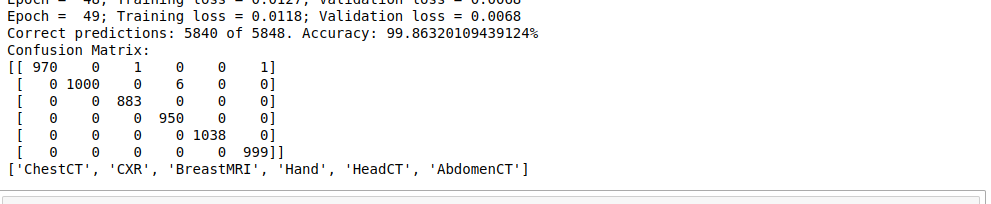